# Reproduction and GAN Implementation Analysis

# 1. Reproduction

This notebook will be analyzing the results of the reproduction of the results from the original World Models paper. Weights for the VAE can be found in `vae/weights.h5`, and weights for the MDN-RNN can be found in `rnn/weights.h5`. 

## VAE

In [41]:
import numpy as np
from vae.arch import VAE
from gan.arch import GAN
import matplotlib.pyplot as plt
import os
from IPython import display
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets
from tensorflow.keras.utils import plot_model
import json
from matplotlib import pyplot as plt
import numpy as np

np.set_printoptions(precision=4, suppress = True)

In [42]:
vae = VAE()
vae.set_weights('./vae/weights.h5')
DIR_NAME = './data/rollout/'
file = os.listdir(DIR_NAME)[200]
print(file)
obs_data = np.load(DIR_NAME + file)['obs']
print(obs_data.shape)

69526869.npz
(300, 64, 64, 3)


KeyboardInterrupt: 

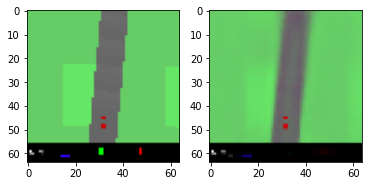

In [49]:
# VAE output with random policy for one episode
for idx in range(0,300):
    plt.gca().cla() 
    
    obs = obs_data[idx]
    z_decoded = vae.full_model.predict(np.array([obs]))[0]
    
    plt.subplot(121)
    plt.imshow( obs)
    plt.subplot(122)
    plt.imshow( z_decoded)
    
#     plt.show()
    display.clear_output(wait=True)
    display.display(plt.gcf())

As you can see, the VAE visually replicates the input images adequately. This means it is likely that `z` encodes important information about the input pixels. The model above was used to generate training data for an MDN-RNN. Use `check_04_rnn.ipynb` to analyze the results from the RNN. 

## Controller

The controller was trained for 171 episodes with a maximum episode length of 300 time steps. As can be seen below, the controller reward steadily increased over time. However, learning the policy was quite slow, with each episode taking many minutes to compute. As can be seen below, there seems to be a relatively good balance of exploration and exploitation throughout training, which is one explanation for the steady rise in reward. The final weights and training history can be found in `log`.

In [43]:
data = json.load(open('log/car_racing.cma.4.8.hist.json'))

In [44]:
xs = [i[0] for i in data]
ys = [i[3] for i in data]

In [45]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

In [33]:
ys_rm = moving_average(ys, 10)

The following shows the speed with which the controller model learned to drive the car around the track. As shown, the model learns slowly and relatively linearly. Given more training time and fewer compute contstraints, I hypothesize that the model will continue to improve. 

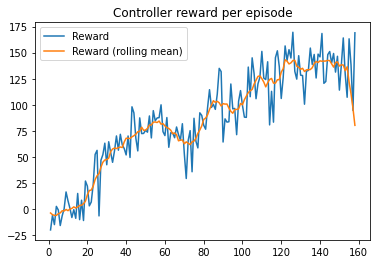

<Figure size 432x288 with 0 Axes>

In [34]:
fig, ax = plt.subplots()
ax.plot(xs, ys, label='Reward')
ax.plot(xs, ys_rm, label='Reward (rolling mean)')
ax.set_title('Controller reward per episode')
ax.legend()
plt.show()
plt.savefig('controller_reward.png')

The following gif shows the behavior of the trained controller. As explained in the original paper, combining a representation of the present state with a prediction of the future produces a driving behavior that is relatively smooth. 
<img src="demo_imgs/animation.gif" width="500" height="500"> 

# GAN Results Analysis

The pipeline was replicated with a slightly different architecture that utilizes a Generative Adverserial network in combination with a Convolutional Variational Autoencoder to produce the latent $z$ variable. The architecture for a VAEGAN is as follows.

Just like with the vanilla VAE, an encoder network turns the input $x$ into a latent vector $z$. The generator then takes the role of the decoder, turning $z$ into a $\hat{x}$ which should reproduce the original image. However, instead of the similarity between $\hat{x}$ and $x$ being used as the metric from which to train the network, an additional network known as the discriminator is used to learn a similarity metric between $x$ and $\hat{x}$. As described in [this paper](https://arxiv.org/pdf/1512.09300.pdf), this allows the network to encode richer information than simply pixel-to-pixel similarity. 

The GAN was trained for approx. 20 epochs with N=100-200.

The specific implementation of the VAE-GAN architecture can be found in `gan/arch.py`. The controller model has been updated to work with the VAE-GAN in `model_gan.py`. Furthermore, a similar pipeline has been created and this experiment can be replicated by running the following python files:

- Collect rollouts with `01_generate_data.py`, or use rollouts present in `data/rollouts`
- run `train_gan.py`
- run `generate_rnn_data_gan.py`. Data stored in `data/series_gan`
- run `train_rnn_gan.py`. Weights for the RNN trained with GAN encodings are stored in `rnn/weights_gan.h5`.
- run `train_controller_gan.py`


The following demonstrates the visual recreation of the VAE-GAN. While not an exact recreation, the RNN and controller are nonetheless shown to eventually learn to use the VAE-GAN's $z$ variable effectively in the car racing environment

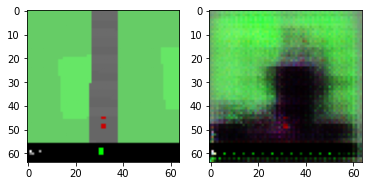

KeyboardInterrupt: 

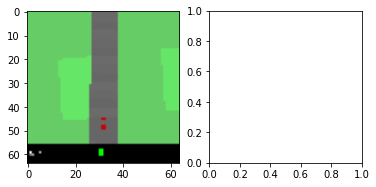

In [50]:
gan = GAN()
gan.set_weights('./gan/weights_1.h5')

for idx in range(0,300):
    plt.gca().cla() 
    
    obs = obs_data[idx]
    z_decoded = gan.full_model.predict(np.array([obs]))[0]
    
    plt.subplot(121)
    plt.imshow( obs)
    plt.subplot(122)
    plt.imshow( z_decoded)
    
#     plt.show()
    display.clear_output(wait=True)
    display.display(plt.gcf())

In my experiments, the training reconstruction does resemble the original image as closely as the vanilla CVAE. However, the controller is still found to be competitive with the VAE approach when it and the RNN are trained with $z$s produced by the GAN. This implies that, while the generator does not visually recreate the original image, important features are still being encoded in its latent $z$. This may be because the discriminator is learning a similarity metric that is more complex than a direct visual recreation. More training could potentially cause the generator to converge to a visual recreation of the original input $x$. Furthermore, the VAE-GAN is slower and more complex to train than the VAE.  

In [46]:
data_gan = json.load(open('log/car_racing.cma.10.4.gan.hist.json'))
xs_gan = [i[0] for i in data_gan]
ys_gan = [i[3] for i in data_gan]
ys_gan_rm = moving_average(ys_gan, 10)

Comparing with the VAE, the GAN performs slightly better after lagging behind for the first 50 steps. In this experiment, the GAN performs better than the VAE despite not being able to visually recreate the input image adequately. Therefore, I hypothesize that given a GAN with more training time and a controller with more training time, the GAN encoder architecture would outperform the VAE. This implies that the information in the GAN's $z$ is somehow richer than that of the VAE, though the low reward early in the controller's training also implies that the information is more complex, and some exploration is required before it can be used.  

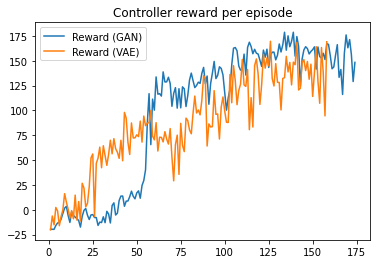

<Figure size 432x288 with 0 Axes>

In [47]:
fig, ax = plt.subplots()
ax.plot(xs_gan, ys_gan, label='Reward (GAN)')
ax.plot(xs, ys, label='Reward (VAE)')
# ax.plot(xs_gan, ys_gan_rm, label='Reward (rolling mean)')
ax.set_title('Controller reward per episode')
ax.legend()
plt.show()
plt.savefig('controller_reward.png')

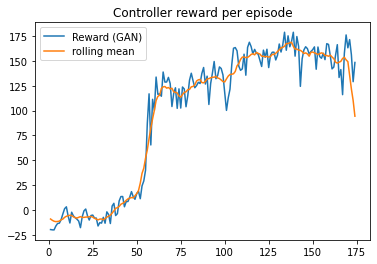

<Figure size 432x288 with 0 Axes>

In [48]:
fig, ax = plt.subplots()
ax.plot(xs_gan, ys_gan, label='Reward (GAN)')
ax.plot(xs_gan, ys_gan_rm, label='rolling mean')
# ax.plot(xs_gan, ys_gan_rm, label='Reward (rolling mean)')
ax.set_title('Controller reward per episode')
ax.legend()
plt.show()
plt.savefig('controller_reward.png')

Below, the GAN controller is shown driving the same track as shown above. It is slightly more "wiggly" but achieves a higher overall score. In this case, that is likely because it sticks to the road during the left turn better than the original model.  

<img src="demo_imgs_gan/animation.gif" width="500" height="500"> 

There are two important takeaways from the results. First, the fact that the GAN produced a functional controller despite not producing a recreated image demonstrates that the direct visual recreation may not be the best way to encode information into the latent space, even though it makes the most sense to human perception. It is possible that the discriminator is learning a more efficient or information-dense representation of $x$ that isn't conducive to an exact recreation but carries more information needed for the car driving task. Alternately, the GAN might need to be trained more to approach visually similar recreations. A second takeaway is that slight alterations to model architectures can have profound effects on the shape of the reward-over-time curves shown below. While the reward from the controller trained with $z$s from the VAE rises relatively linearly, the reward from the controller trained with $z$s from the VAE-GAN stayed low for about 50 steps before jumping up to levels competitive with the VAE.